In [29]:
import psycopg2
import sys
import pprint
import pandas
import random

In [30]:
def connect():
    "return a connection"
    conn_string = "host='localhost' dbname='mimic' user='postgres'"
    conn = psycopg2.connect(conn_string)
    return conn
    
def disconnect(conn):
    "disconnect"
    conn.commit()
    conn.close()

def get_data( query, itersize=10000):
    "return a pandas dataframe with columns names"
    conn = connect()
    cur = conn.cursor(f'tmpCursor')
    cur.itersize = itersize
    cur.execute(query)
    pd = pandas.DataFrame(cur.fetchall(),columns= [desc[0] for desc in cur.description])
    cur.close()
    disconnect(conn)
    return pd


In [ ]:
print(get_data("select itemid from mimiciii.d_items where lower(label) like '%evophed%' or lower(label) like '%pressin%' or lower(label) like '%ephrin%' "))

In [84]:
 print(get_data("SELECT table_schema, table_name FROM information_schema.tables WHERE table_schema IN (  'mimiciii')"))

   table_schema          table_name
0      mimiciii    d_icd_procedures
1      mimiciii          admissions
2      mimiciii             callout
3      mimiciii          caregivers
4      mimiciii       chartevents_1
5      mimiciii       chartevents_2
6      mimiciii       chartevents_3
7      mimiciii       chartevents_4
8      mimiciii       chartevents_5
9      mimiciii       chartevents_6
10     mimiciii       chartevents_7
11     mimiciii       chartevents_8
12     mimiciii       chartevents_9
13     mimiciii      chartevents_10
14     mimiciii      chartevents_11
15     mimiciii      chartevents_12
16     mimiciii      chartevents_13
17     mimiciii      chartevents_14
18     mimiciii         chartevents
19     mimiciii           cptevents
20     mimiciii      datetimeevents
21     mimiciii       diagnoses_icd
22     mimiciii            drgcodes
23     mimiciii               d_cpt
24     mimiciii     d_icd_diagnoses
25     mimiciii             d_items
26     mimiciii          d_l

In [83]:
 print(get_data("SELECT * FROM sepsis.general_vars LIMIT 10"))

   subject_id  hadm_id
0           2   163353
1           3   145834
2           4   185777
3           5   178980
4           6   107064
5           7   118037
6           8   159514
7           9   150750
8          10   184167
9          11   194540


In [148]:
ref = get_data("SELECT * FROM mimiciii.d_items WHERE label ~* 'temp' AND linksto = 'chartevents'")
print(ref)
ref.to_csv('ITEMS_TEMP_20170606.csv')

    row_id  itemid                                              label  \
0      548     591                                  RLE [Temperature]   
1      554     597                                  RUE [Temperature]   
2      384     417                                  Inspired Gas Temp   
3      391     424                                         LLE [Temp]   
4      394     427                                         LUE [Temp]   
5      598     645                                 Skin [Temperature]   
6      626     674                                         Temp. Site   
7      627     676                                      Temperature C   
8      628     677                               Temperature C (calc)   
9      629     678                                      Temperature F   
10     630     679                               Temperature F (calc)   
11    1053    3460                               Humidity Temp [Meas]   
12    1740    5632                                R

In [145]:
def inStmt(col):
    "generates list"
    return ','.join(col.map(str))

In [231]:
cardiac_index = pandas.read_csv("ITEMS_CARDIAC_INDEX_201511111831.csv")
mean_pressure = pandas.read_csv("ITEMS_MEAN_PRESSURE_201511111723.csv")
systol_pressure = pandas.read_csv("ITEMS_SYSTOL_PRESSURE_201511111657-3.csv")
thromb = pandas.read_csv("ITEMS_THROMB_201511111845.csv")
venus_sat = pandas.read_csv("ITEMS_VENUS_SAT_201511111810.csv")
weight = pandas.read_csv("ITEMS_WEIGHT_20170606.csv")
temp = pandas.read_csv("ITEMS_TEMP_20170606.csv")
tmp = temp[temp['conceptid'] == True]
print(inStmt(tmp['itemid']))
a = get_data("SELECT * FROM mimiciii.d_icd_diagnoses")
a.to_csv('diag.csv')

591,597,424,427,645,674,676,677,678,679,3652,3654,3655,8537,6643,224027,224390,224642,228242,223761


In [341]:
print(get_data('WITH urine AS (SELECT icustay_id, value, charttime, ROW_NUMBER() OVER(PARTITION BY icustay_id ORDER BY charttime) as position \
FROM mimiciii.outputevents WHERE  itemid = 40055  ),\
              tmp as ( SELECT o1.icustay_id, o1.position, o2.position, o1.charttime, o2.charttime, EXTRACT(epoch FROM (o2.charttime - o1.charttime))/3600 as duree, coalesce(o2.value,o1.value) as val,   \
               coalesce(o2.value,o1.value) / (EXTRACT(epoch FROM (o2.charttime - o1.charttime))/3600) vol_per_hour, \
               CASE WHEN (coalesce(o2.value,o1.value) / (EXTRACT(epoch FROM (o2.charttime - o1.charttime))/3600) < 22.5 AND EXTRACT(epoch FROM (o2.charttime - o1.charttime))/3600 >=2) THEN \
               TRUE \
               END as result \
               FROM urine o1\
               LEFT JOIN urine o2 \
               ON \
               o1.icustay_id = o2.icustay_id \
               AND o1.position = o2.position -1 \
              AND o1.charttime <> o2.charttime) \
               SELECT distinct on (icustay_id) icustay_id FROM tmp WHERE result IS TRUE'))

    icustay_id  position  position           charttime           charttime  \
0       200019         5         6 2178-07-08 18:00:00 2178-07-08 20:00:00   
1       200019        30        31 2178-07-10 04:00:00 2178-07-10 06:00:00   
2       200019        31        32 2178-07-10 06:00:00 2178-07-10 09:00:00   
3       200019        35        36 2178-07-10 12:00:00 2178-07-10 14:00:00   
4       200019        40        41 2178-07-10 18:00:00 2178-07-10 20:00:00   
5       200019        41        42 2178-07-10 20:00:00 2178-07-10 23:00:00   
6       200019        42        43 2178-07-10 23:00:00 2178-07-11 02:00:00   
7       200019        43        44 2178-07-11 02:00:00 2178-07-11 05:00:00   
8       200039         2         3 2121-12-26 08:00:00 2121-12-26 10:00:00   
9       200039         6         7 2121-12-26 18:00:00 2121-12-26 20:00:00   
10      200045        39        40 2116-07-12 09:00:00 2116-07-12 11:00:00   
11      200045       431       432 2116-07-29 12:00:00 2116-07-2

In [393]:
print(get_data(f'SELECT max(valuenum), avg(valuenum),  count(1), itemid, valueuom, label \
FROM mimiciii.chartevents \
JOIN mimiciii.d_items USING (itemid) \
WHERE valuenum IS NOT NULL AND itemid IN (225678, 227457, 828, 3789, 6256) \
GROUP BY valueuom, itemid, label order by count DESC;'))

        max         avg   count  itemid valueuom                label
0    2292.0  218.370891  188850     828     None            Platelets
1  999999.0  224.696646  137351  227457     K/uL       Platelet Count
2    1147.0  282.603895   10449    3789     None  Platelet  (150-440)
3     533.0  180.966990     103  227457     None       Platelet Count


In [209]:
print(get_data(f'SELECT max(valuenum), avg(valuenum),  count(1), itemid, valueuom, label \
FROM mimiciii.chartevents \
JOIN mimiciii.d_items USING (itemid) \
WHERE valuenum IS NOT NULL AND valuenum < 155 AND  itemid IN (818, 1531, 225668) \
GROUP BY valueuom, itemid, label order by count DESC;'))

     max        avg  count  itemid valueuom                 label
0  153.0   2.847933  73025     818     None  Lactic Acid(0.5-2.0)
1   32.0   2.505627  69381  225668   mmol/L           Lactic Acid
2  153.0   2.778967  63233    1531     None           Lactic Acid
3  150.0  36.469767     43  225668     None           Lactic Acid


In [228]:
print(get_data("SELECT max(value), avg(value), median(value::numeric), count(1), itemid, label \
        FROM mimiciii.outputevents cd\
        JOIN mimiciii.d_items USING (itemid) \
        WHERE\
        label ~* 'urin'\
        AND  value != 0\
        GROUP BY valueuom, itemid, label order by count DESC;" ))

          max          avg                  median    count  itemid  \
0    11000.00   120.452865     80.0000000000000000  1879287   40055   
1     2220.00    21.267898     18.0000000000000000   103610   43175   
2     3775.00   291.912651    250.0000000000000000    62032   40069   
3     3400.00   273.367249    200.0000000000000000     8354   40094   
4     1600.00   120.367487     80.0000000000000000     6705   40715   
5     8300.00   681.527274    405.0000000000000000     5848  226627   
6     2000.00   131.609542    100.0000000000000000     4674   40473   
7    19990.00   909.020668    750.0000000000000000     4161   40065   
8     8000.00   599.445980    330.0000000000000000     3993   40061   
9    28000.00  1872.169801   1600.0000000000000000     3116  227489   
10    1350.00   137.628167    100.0000000000000000     2684   40057   
11     850.00   109.790960     75.0000000000000000     2655   40056   
12    4000.00   155.555754    100.0000000000000000     1677   40405   
13    

In [221]:
print(get_data("SELECT * FROM mimiciii.d_items WHERE label ~* 'urin'"))

     row_id  itemid                                              label  \
0      1162     941                                      urine culture   
1      1182    1011                                   urine osmolarity   
2      1671    4855                                      Urine culture   
3      1361    1352                                           urine pH   
4       656     706                                      Urine [Color]   
5       657     707                                       Urine Source   
6       816    3140                                          Urine Cl-   
7      3251    1880                                           Urine pH   
8      3273    1917                                          Urine Na+   
9      3274    1918                                          Urine Osm   
10     3275    1919                                        Urine creat   
11     2446    6035                                    Urinalysis sent   
12     1913    5810                   

In [38]:
ci=cardiac_index[cardiac_index['valid'] == True]
mp=mean_pressure[mean_pressure['valid'] == True]
sp=systol_pressure[systol_pressure['valid'] == True]
th=thromb[thromb['valid'] == True]
vs=venus_sat[venus_sat['valid'] == True]

In [342]:
print(get_data('SELECT count(1)  FROM sepsis.angus2013_sepsis_severe WHERE hadm_id NOT IN (SELECT hadm_id FROM sepsis.angus2013_sepsis)'))

   count
0      0


In [399]:
#TEST IF JEROME CODES ARE OK
import re
f = open('infect_icd9_jab.txt')
inf = f.read()
inf = list(filter(len,re.split("\s+|\n", inf)))
inf = [x for x in inf if len(x) != 3]
#inf = list(filter(len,re.split("\s+|\n", inf)))
pred = "'),('".join(inf)
#get_data(f"WITH inf as (SELECT column1 as cd FROM (VALUES ('{pred}')) as tmp)\
#         SELECT count(1) FROM inf WHERE cd NOT IN (SELECT icd9_code FROM mimiciii.diagnoses_icd) ")
get_data(f"WITH inf as (SELECT column1 as cd FROM (VALUES ('{pred}')) as tmp)\
           SELECT count(distinct hadm_id) \
           FROM mimiciii.diagnoses_icd \
           WHERE icd9_code IN (SELECT * FROM inf)")
pred = "','".join(list(set(inf)))
a =(f"SELECT DISTINCT subject_id, hadm_id \
FROM mimiciii.diagnoses_icd \
WHERE icd9_code IN ('{pred}')")
f1=open('jero_icd9.sql', 'w+')
f1.write(a)


17072

In [423]:
import pylab as plt
from matplotlib_venn import venn3
# ACCP: dans infection icd9
# 2 critères dans chap general et inflamatory
# 1 dans Soit organ disf SOIT tissue hypo SOIT émodynamique variable
accp_sql = get_data('WITH crit1 AS (SELECT hadm_id FROM sepsis.ch0_infection_pop), \
tmp AS (SELECT count(1), hadm_id FROM ( SELECT hadm_id FROM sepsis.ch1_general_vars_temp UNION ALL  SELECT hadm_id FROM sepsis.ch1_general_vars_hr UNION ALL SELECT hadm_id FROM sepsis.ch1_general_vars_rr UNION ALL  SELECT hadm_id FROM sepsis.ch1_general_vars_glasgow UNION ALL  SELECT hadm_id FROM sepsis.ch1_general_vars_gly UNION ALL  SELECT hadm_id FROM sepsis.ch1_general_vars_fluid ) as tmp GROUP BY hadm_id) ,\
crit2 as (SELECT hadm_id FROM tmp WHERE count >= 2), \
crit3 as (SELECT hadm_id FROM (SELECT hadm_id FROM sepsis.ch4_organ_dysf_art_hypox UNION ALL SELECT hadm_id FROM sepsis.ch4_organ_dysf_creat UNION ALL SELECT hadm_id FROM sepsis.ch4_organ_dysf_thromb UNION ALL SELECT hadm_id FROM sepsis.ch4_organ_dysf_plat UNION ALL SELECT hadm_id FROM sepsis.ch4_organ_dysf_urin UNION ALL SELECT hadm_id FROM sepsis.ch5_tissue_perf) as tmp2) \
SELECT DISTINCT hadm_id FROM (SELECT * FROM crit1 INTERSECT SELECT * FROM crit2 INTERSECT SELECT * FROM crit3) as tmp3 \
                    ')
#Sepsis3: dans infection icd9
# sofa >= 2 
# lactate <2 ou abs
sepsis_severe_sql = get_data('SELECT distinct hadm_id FROM angus2013_sepsis_severe')
#BCSC: only codes
# +  le meme jour toutes ces choses là:
# prélevement
# bacterio
# remplissage
sepsis_shock_sql = get_data('SELECT distinct hadm_id FROM angus2013_sepsis_severe' )
set1 = set(accp_sql['hadm_id'])
#idx = df['sepsis_angus']==1 
set2 = set(sepsis_severe_sql['hadm_id']) 
#idx = df['sofa']>=2 
set3 = set(sepsis_shock_sql['hadm_id'])
set3=set2


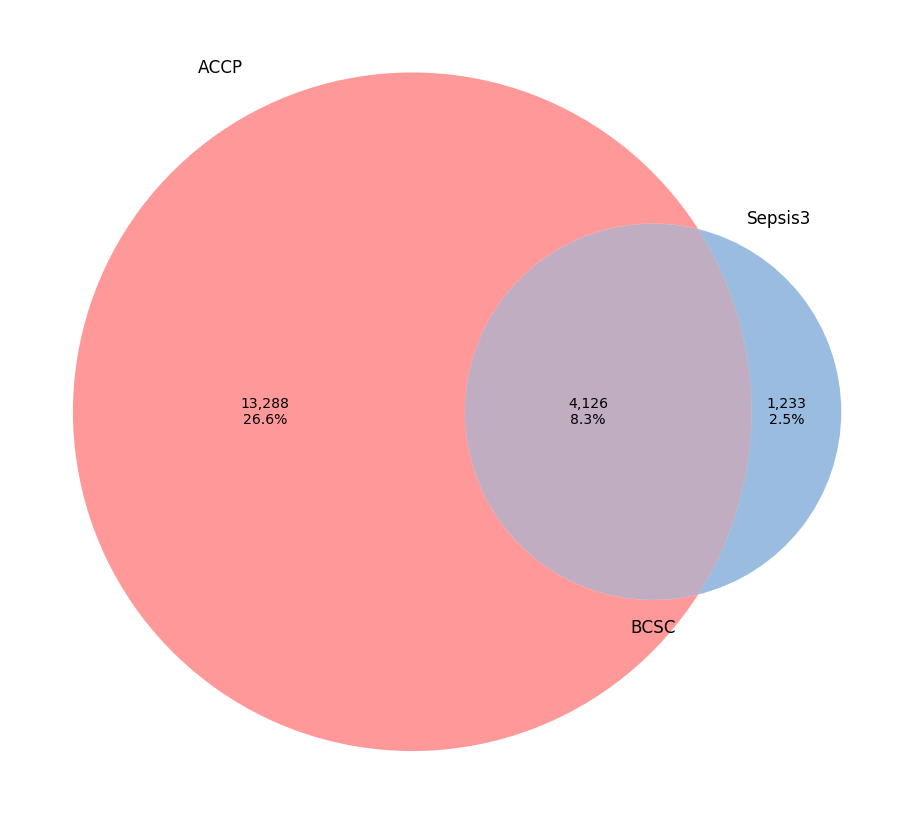

In [424]:
plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 14})
venn3([set1, set2, set3], ('ACCP', 'Sepsis3', 'BCSC'),      
subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/50000))
plt.savefig('sepsis3-venn.png')
plt.show()